# 🩺 Introduction

Leukemia is a life-threatening disease. Leukemia occurs in two forms, acute or chronic. Acute leukemia develops faster than chronic leukemia and shows more intense symptoms. Acute lymphoblastic leukemia (ALL) is the most common type of cancer in childhood. While 80% of childhood leukemias are ALL, it is 20% of adult leukemias. The methods used to diagnose ALL are time-consuming and complex. In this notebook, ALL diagnosis is performed automatically using microscopic images of blood cells. Firstly, features are extracted from the images using pre-trained CNN-based deep network architectures, and then feature selection methods are used to select the relevant features from the large-size feature set obtained. Finally, machine learning algorithms are used for classification.

![image.png](attachment:478516fe-2839-463a-929d-1214858f3653.png)


### 📌 Content

1. [Load and Check Data](#1)
1. [Crop Black Edges In Image](#2)
1. [Feature Extraction with VGG19, ResNet50 or ResNet101](#3)
1. [Data Scaling](#4)
1. [Feature Selection Methods](#5)
    * [ANOVA](#6)
    * [Recursive Feature Elimination (RFE)](#7)
    * [Random Forest](#8)
1. [Train / Test Split](#9)
1. [Classification with ML Algorithms](#10)
    * [kNN](#11)
    * [SVM](#12)
    * [Random Forest](#13)
    * [Naive Bayes](#14)


In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id='1'></a><br>
# Load and Check Data

In [3]:
healthy = "/content/drive/MyDrive/DFU Dataset/train/Healthy"

ulcer = "/content/drive/MyDrive/DFU Dataset/train/Ulcer"

In [4]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder)
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)

    return image_paths

In [5]:
img_data = []

for i in [healthy, ulcer]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

844


In [6]:
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data = pd.DataFrame(data)

In [7]:
data["labels"][0:411] = 1 # ALL
data["labels"][411:844] = 0 # HEM

<ipython-input-7-551c12771f6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][0:411] = 1 # ALL
<ipython-input-7-551c12771f6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][411:844] = 0 # HEM


In [8]:
data["labels"] = data["labels"].astype("int64")

<a id='2'></a><br>
# Crop Black Edges In Image

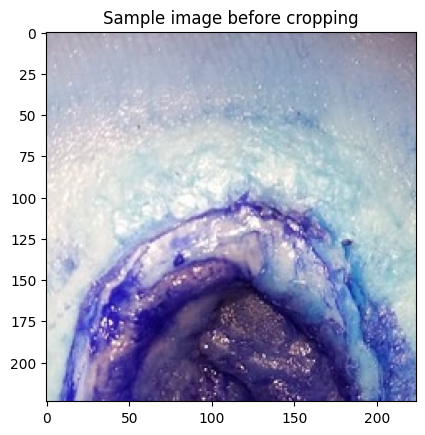

In [ ]:
image = cv.imread(data["img_data"][433])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [9]:
img_list = []
for i in range(len(img_data)):
    image = cv.imread(data["img_data"][i])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255]
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (224,224))
    img_list.append(crop_img_r)

<a id='3'></a><br>
# Feature Extraction with VGG19, ResNet50 or ResNet101

In [10]:
from tensorflow.keras.applications import ResNet50, ResNet101
from keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [13]:
input_shape = (224, 224, 3)
inputs = Input(input_shape)

res   = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)

In [14]:
multi_net = Concatenate()([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(res)])
model = Model(inputs, multi_net)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg19 (Functional)          (None, 7, 7, 512)            2002438   ['input_3[0][0]']             
                                                          4                                       
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_3[0][0]']             
                                                          2                                       
                                                                                              

In [ ]:
def feature_extract(model):
    if model == "VGG19": model = VGG19(weights='imagenet',include_top=False, pooling="avg")
    elif model == "ResNet50": model = ResNet50(weights='imagenet',include_top=False,pooling="avg")
    elif model == "ResNet101": model = ResNet101(weights='imagenet',include_top=False,pooling="avg")
    return model

In [ ]:
model = feature_extract("ResNet50") # or "VGG19", "ResNet101"

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [15]:
features_list = []
for i in range(len(img_list)):

    image = img_list[i].reshape(-1, 224, 224, 3)
    image = preprocess_input(image)


    # Reshaping when VGG19 model is selected
    #features = model.predict(image).reshape(512,)


    #Reshaping  when ResNet50 or ResNet101 model is selected
    features = model.predict(image).reshape(2560,)

    features_list.append(features)

1/1 [==============================] - 1s 1s/step


In [16]:
features_df = pd.DataFrame(features_list)

In [17]:
features_df["labels"] = data["labels"]

In [18]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [19]:
x

,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559
0,0.037981,0.288521,0.000000,0.222980,0.300154,0.000000,0.000000,0.083659,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.238513,0.000000,0.049488,0.000000,0.149954,0.000000,0.000000
1,0.227271,0.000000,0.070660,0.000000,0.074883,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.163882,0.000000,0.013522,0.000000,0.000000,0.000000,0.000000,0.039937,0.040340,0.077818
2,0.670171,0.000000,0.438123,0.000000,0.465537,0.000000,0.000000,0.302342,0.000000,0.077459,...,0.000000,0.002935,0.000000,0.105852,0.000000,0.000000,0.000000,0.090420,0.000000,0.001337
3,0.567013,0.000000,2.581463,0.000000,0.574477,0.000000,0.000000,1.649082,0.000000,0.000000,...,0.000000,0.058737,0.000000,0.000000,0.000000,0.000000,0.000000,0.082448,0.000000,0.002654
4,0.000000,0.014561,0.000000,0.000000,1.990275,0.130532,0.000000,3.301392,0.000000,0.520304,...,0.000000,0.102235,0.071375,0.000000,0.024179,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,6.671841,2.791679,3.233129,0.889171,0.085526,0.964399,3.815379,0.083511,0.029983,2.380657,...,0.000000,0.000000,0.191714,0.058700,0.183932,0.196448,0.023298,0.044613,0.510564,0.336854
840,2.256785,0.999207,0.000000,1.585598,0.033434,0.097982,0.096569,0.221834,0.000000,1.339696,...,0.001720,0.813648,3.098485,0.361452,0.401510,0.000000,0.534490,0.319577,0.082020,0.276775
841,11.483565,0.911263,4.496857,4.840283,3.909256,1.991868,0.173335,0.040476,1.024143,0.000000,...,0.000000,0.090168,0.208909,0.000000,0.846436,0.142554,0.000000,0.077820,0.231737,0.140509
842,11.609451,3.257434,0.000000,5.875185,0.231572,2.203151,0.427860,0.000000,0.356081,2.896622,...,0.039343,0.465064,3.790626,0.017658,0.387620,0.074232,0.000000,0.000000,0.002037,0.460596


In [20]:
print(f"Number of features before feature selection: {x.shape[1]}")

Number of features before feature selection: 2560


In [21]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

<a id='4'></a><br>
# Data Scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x_ = scaler.transform(x)

In [23]:
x_ = pd.DataFrame(x_)

<a id='5'></a><br>
# Feature Selection Methods

<a id='6'></a><br>
## ANOVA

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova_fs():

    selector = SelectKBest(f_classif, k=500) # k is number of features
    selector.fit(x_, y)

    cols = selector.get_support(indices=True)
    anova_x = x_[cols]
    return anova_x

<a id='7'></a><br>
## Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def RFE_fs():
    rfe_selector = RFE(estimator=RandomForestClassifier())
    rfe_selector.fit(x_, y)

    rfe_support = rfe_selector.get_support()
    rfe_feature = x_.loc[:,rfe_support].columns.tolist()

    rfe_x = x_[rfe_feature]
    return rfe_x

<a id='8'></a><br>
## Random Forest

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def rf_fs():
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=5), threshold='1.25*median')
    embeded_rf_selector.fit(x, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = x.loc[:,embeded_rf_support].columns.tolist()

    rf_x = x[embeded_rf_feature]
    return rf_x

In [25]:
#fs_x = rf_fs() # feature selection methods "anova_fs", "RFE_fs"
fs_x = anova_fs() # feature selection methods "anova_fs", "RFE_fs"

In [26]:
print(f"Number of features after feature selection: {fs_x.shape[1]}")

Number of features after feature selection: 500


<a id='9'></a><br>
# Train Test Split

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(fs_x, y, test_size = 0.2, random_state = 42)

<a id='10'></a><br>
# Classification with ML Algorithms

In [28]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

<a id='11'></a><br>
## kNN

In [29]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    prediction_ = knn.predict(x_test)
    train_accuracy.append(knn.score(x_train, y_train))
    test_accuracy.append(knn.score(x_test, y_test))

print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

Best accuracy is 0.9467455621301775 with K = 1


In [30]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(x_train,y_train)
predicted = knn.predict(x_test)
score = knn.score(x_test, y_test)
knn_score_ = np.mean(score)

print('Accuracy : %.3f' % (knn_score_))

Accuracy : 0.917


In [31]:
p=precision_score(y_test, predicted)
print('Precision : %.3f' % (p))

r=recall_score(y_test, predicted)
print('Recall : %.3f' % (r))

f1=f1_score(y_test, predicted)
print('F1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted')
print('Weighted f1-score: %.3f' % (f1_w))

Precision : 0.856
Recall : 1.000
F1-score: 0.922
Weighted f1-score: 0.917


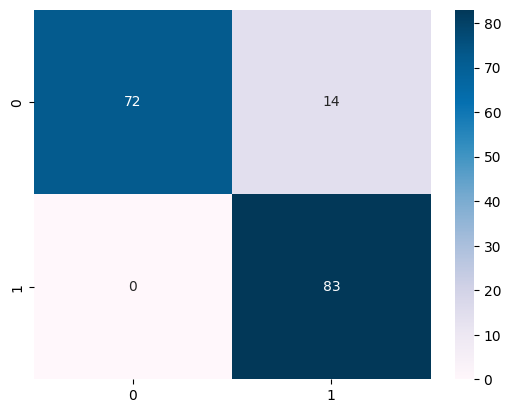

In [32]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

<a id='12'></a><br>
## SVM

In [33]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}

SVM_grid = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
SVM_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [34]:
print(SVM_grid.best_params_)

print(SVM_grid.best_estimator_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


In [35]:
svm_clf = svm.SVC(C=100, gamma=0.01, kernel='rbf')
svm_clf.fit(x_train,y_train)
predicted = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.964


In [36]:
p=precision_score(y_test, predicted)
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted)
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted)
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted')
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.943
recall : 0.988
f1-score: 0.965
weighted f1-score: 0.964


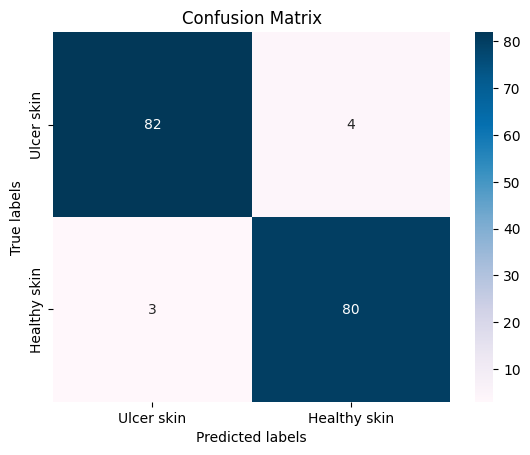

In [48]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Ulcer skin', 'Healthy skin']); ax.yaxis.set_ticklabels(['Ulcer skin', 'Healthy skin'])
plt.savefig('CM_heatmapas',dpi=400)
plt.show()

<a id='13'></a><br>
## Random Forest

In [38]:
param_grid_rf = {
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8]}

RF_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv= 5)
RF_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [39]:
print(RF_grid.best_params_)

{'max_depth': 4, 'n_estimators': 500}


In [40]:
r_forest = RandomForestClassifier(500,max_depth=8, random_state=5)
r_forest.fit(x_train,y_train)
predicted = r_forest.predict(x_test)
score = r_forest.score(x_test, y_test)
rf_score_ = np.mean(score)

print('Accuracy : %.3f' % (rf_score_))

Accuracy : 0.964


In [41]:
p=precision_score(y_test, predicted)
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted)
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted)
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted')
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.943
recall : 0.988
f1-score: 0.965
weighted f1-score: 0.964


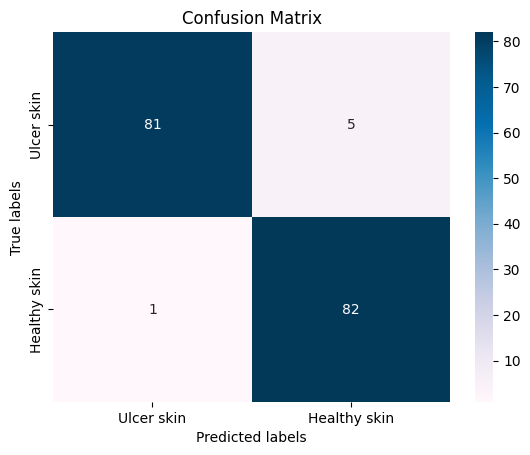

In [43]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Ulcer skin', 'Healthy skin']); ax.yaxis.set_ticklabels(['Ulcer skin', 'Healthy skin'])
plt.savefig('CM_heatmap',dpi=400)
plt.show()

<a id='14'></a><br>
## Naive Bayes

In [44]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)
predicted = nb_model.predict(x_test)
score = nb_model.score(x_test, y_test)
nb_score_ = np.mean(score)

print('Accuracy : %.3f' % (nb_score_))

Accuracy : 0.959


In [45]:
p=precision_score(y_test, predicted)
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted)
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted)
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted')
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.952
recall : 0.964
f1-score: 0.958
weighted f1-score: 0.959


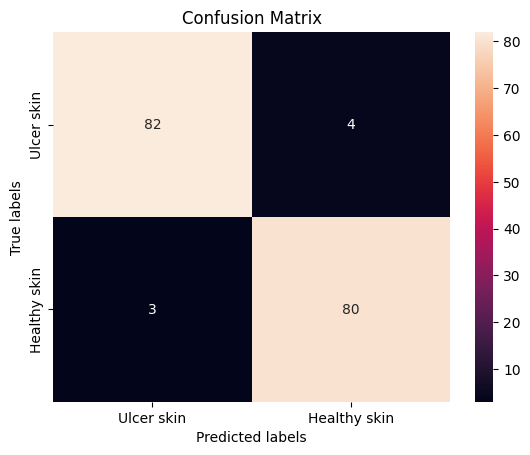

In [47]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Ulcer skin', 'Healthy skin']); ax.yaxis.set_ticklabels(['Ulcer skin', 'Healthy skin'])
plt.savefig('CM_heatmap1',dpi=400)
plt.show()